# Data Loading

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [176]:
def read_users():
    users = {}
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_user.json", lines = True, chunksize = 10000)
    for chunk in chunks:
        for index, row in chunk.iterrows():
            users[row['user_id']] = row
    return users        
users = read_users()

In [103]:
from collections import defaultdict
from dateutil import parser

def get_reviews():
    review_map = defaultdict(list)
    average_ratings = defaultdict(list)
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_review.json", lines = True, chunksize = 3000)
    for chunk in chunks:
        for index, row in chunk.iterrows():
            bid = row["business_id"]
            review_map[row['user_id']].append((row["date"], row["stars"], bid))
            average_ratings[bid].append(int(row["stars"]))
    final_average_ratings = {}
    for b in average_ratings.keys():
        final_average_ratings[b] = np.mean(average_ratings[b])
    return final_average_ratings, review_map
    
final_average_ratings, review_map = get_reviews()

In [52]:
def get_business_map():
    business_map = {}
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_business.json", lines = True, chunksize = 3000)
    for chunk in chunks:
        for index, row in chunk.iterrows():
            business_map[row["business_id"]] = row
    return business_map
business_map = get_business_map()

In [207]:
def get_ca_bids():
    ca_bids = []
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_business.json", lines = True, chunksize = 3000)
    for chunk in chunks:
        rows = chunk.loc[chunk['state'] == "CA"]
        ca_bids.extend(rows["business_id"])        
    return ca_bids
ca_bids = get_ca_bids()

In [67]:
from sklearn.preprocessing import OneHotEncoder

def generate_category_encoder_input(categories):
    array = [""] * 5
    try:
        a = categories.split(', ')
        for i in range(min(5, len(a))):
            array[i] = a[i]
    except AttributeError:
        pass
    return array

def get_category_encoder():
    chunks = pd.read_json("./yelp_dataset/yelp_academic_dataset_business.json", lines = True, chunksize = 10000)
    ohv_training = []
    for chunk in chunks:
        for index, row in chunk.iterrows():
            array = generate_category_encoder_input(row["categories"])
            ohv_training.append(array)
    enc = OneHotEncoder(handle_unknown="ignore")
    enc.fit(ohv_training)
    return enc

def get_event_embedding(bid, category_encoder):
    business = business_map[bid] 
    picked_features = np.array([business["stars"], business["review_count"], business["is_open"]])
    o = generate_category_encoder_input(business["categories"])
    category_features = category_encoder.transform([o]).A[0]
    return np.concatenate((picked_features, category_features))
        
def generate_user_history_embedding(uid, category_encoder, decay = False, **args):
    reviews = review_map[uid]
    dim = category_encoder.transform([[""] * 5]).shape[1]
    if len(reviews) == 0:
        return np.zeros(3 + dim)
    start = np.zeros(3 + dim)
    n_reviews = len(review_map[uid])
    for review_date, stars, bid in review_map[uid]:
        emb_value = get_event_embedding(bid, category_encoder) * (stars - 3)
        if not decay:
            start += 1/n_reviews * emb_value
        else:
            start *= args["args"]["decay_factor"]
            start += emb_value
    return start

In [ ]:
user_history_cache = {}
user_history_decay_cache = {}

In [5]:
enc = get_category_encoder()

In [16]:
import pickle

def dump_var(var, filename):
    with open(filename, "wb") as f:
        pickle.dump(var, f)

def load_var(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

In [177]:
dump_var(review_map, "review_map.pkl")
dump_var(business_map, "business_map.pkl")
dump_var(final_average_ratings, "final_average_ratings.pkl")
dump_var(users, "user_map.pkl")

In [22]:
users = load_var("user_map.pkl")
business_map = load_var("business_map.pkl")

In [ ]:
review_map = load_var("review_map.pkl")

## Dataset Analysis

/var/folders/qk/l24kr0vd3w1ccfx8ng5tp3l00000gr/T/ipykernel_9693/478392250.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


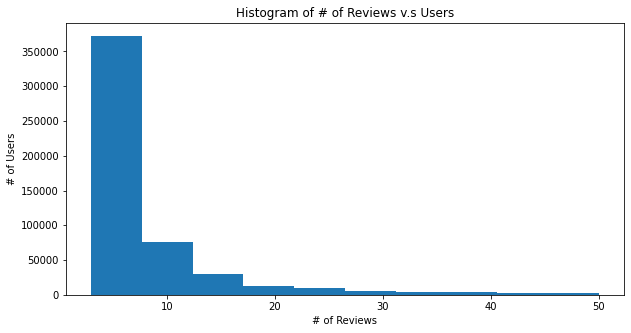

In [287]:
import matplotlib.pyplot as plt
n = []
fig, ax = plt.subplots(figsize = (10 ,5))
for key, value in review_map.items():
    n.append(len(value))
ax.hist(n, range = (3, 50))
ax.set_title("Histogram of # of Reviews v.s Users")
ax.set_ylabel("# of Users")
ax.set_xlabel("# of Reviews")
fig.show()

In [111]:
print(len(business_map) ** 3)

3398408913621736


In [281]:
len(business_map) 

150346

In [284]:
len(users)

1987897

In [296]:
len(review_map)

1987929

In [112]:
state_generator = lambda s : (s[0][-1], s[1][-1], s[2][-1])
state_distribution = defaultdict(int)

total = 0
for k, v in review_map.items():
    if len(v) < 3:
        continue
    v.sort()
    for i in range(len(v) - 2):
        s = state_generator(v[i: i + 3])
        total += 1
        state_distribution[s] += 1
for k in state_distribution.keys():
    state_distribution[k] = state_distribution[k] / total

In [291]:
len(state_distribution)

4144461

## Generate Data Points

In [10]:
def true_q_func(sequence, gamma = 0.5):
    reward = np.sum([(gamma ** i) * int(v[1]) for i, v in enumerate(sequence)])
    return reward

In [11]:
def create_data_points(gamma = 0.5):
    data_points = [] # (user, last three events, action), q_value
    for user, reviews in review_map.items():
        reviews.sort()
        state = (0,0,0)
        for i, review in enumerate(reviews):
            q_value = true_q_func(reviews[i:], gamma = gamma)
            data_points.append(((user, state, review[-1]), q_value))
            state = (state[1], state[2], review[-1])
    return data_points

In [ ]:
data_points = create_data_points()

In [74]:
data_points_low_gamma = create_data_points(gamma = 0.2)

In [17]:
data_points = load_var("data_points.pkl")

## State Engineering + Regression

## User Only, User and Business
Generating states from hand-picked items.

In [64]:
def user_only(user_id, state, action_taken):
    user = users[user_id]
    compliment_data = user.filter(regex="compliment*")
    v = compliment_data.to_numpy(dtype = int)
    return np.concatenate((v, [int(user["review_count"]), float(user["average_stars"]), len(user["friends"])]))

def user_and_business(user_id, state, action_taken):
    user_vec = user_only(user_id, state, action_taken)
    return np.concatenate((user_vec, get_event_embedding(action_taken, enc)))
    
def user_and_business_abbreviate_history(user_id, state, action_taken, decay = False, **decay_args):
    user_vec = user_only(user_id, state, action_taken)
    business_embedding = get_event_embedding(action_taken, enc)
    bn = np.linalg.norm(business_embedding, ord = 2)
    if bn == 0:
        return np.concatenate((user_vec, business_embedding, [0]))
    user_history_embedding = None
    if decay and user_id in user_history_decay_cache:
        user_history_embedding = user_history_decay_cache[user_id]
    if not decay and user_id in user_history_cache:
        user_history_embedding = user_history_cache[user_id]
    if user_history_embedding is None:
        user_history_embedding = generate_user_history_embedding(user_id, enc, decay = decay, args = decay_args)
        if decay:
            user_history_decay_cache[user_id] = user_history_embedding
        else:
            user_history_cache[user_id] = user_history_embedding
    un = np.linalg.norm(user_history_embedding, ord = 2)
    if un == 0:
        return np.concatenate((user_vec, business_embedding, [0]))
    similarity_feature = user_history_embedding.dot(business_embedding) / (un * bn)
    return np.concatenate((user_vec, business_embedding, [similarity_feature]))
    
def generate_regression_dataset(f, num_points, dataset):
    x_array = []
    y_array = []
    if num_points >= 0:
        dataset_indices = np.random.choice(dataset.shape[0], size = num_points, replace = True) 
    else:
        dataset_indices = np.arange(dataset.shape[0])
    for i, dp in enumerate(dataset[dataset_indices]):
        if i % (num_points / 5) == 0:
            print(i)
        try:
            q_value = dp[1]
            x = f(*dp[0])
            x_array.append(x)
            y_array.append(q_value)
        except KeyError as e:
            print('KeyError: ', e)
            continue
    return x_array, y_array

### Dataset Generation

In [23]:
test_x_u, test_y_u = generate_regression_dataset(user_only, 15000, np.array(data_points, dtype=object))

0
3000
6000
9000
12000


In [31]:
test_x_ub, test_y_ub = generate_regression_dataset(user_and_business, 15000, np.array(data_points, dtype=object))

0
3000
6000
9000
12000


In [41]:
test_x_ubh, test_y_ubh = generate_regression_dataset(user_and_business_abbreviate_history, 15000, np.array(data_points, dtype=object))

0
3000
6000
9000
12000


In [68]:
decay = 0.7
user_and_business_abbreviate_history_with_decay = lambda user_id, state, action_taken : \
user_and_business_abbreviate_history(user_id, state, action_taken, decay = True, decay_factor = decay)

test_x_ubh_decay, test_y_ubh_decay = generate_regression_dataset(user_and_business_abbreviate_history_with_decay, 15000, np.array(data_points, dtype=object))

0
3000
6000
9000
12000


### Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

x, xt, y, yt = train_test_split(test_x_u, test_y_u, test_size = 0.2, random_state=6998)

In [33]:
x2, xt2, y2, yt2 = train_test_split(test_x_ub, test_y_ub, test_size = 0.2, random_state=6998)

In [43]:
x3, xt3, y3, yt3 = train_test_split(test_x_ubh, test_y_ubh, test_size = 0.2, random_state=6998)

In [69]:
x4, xt4, y4, yt4 = train_test_split(test_x_ubh_decay, test_y_ubh_decay, test_size = 0.2, random_state=6998)

In [27]:
reg = LinearRegression().fit(x,y)

linreg_score = reg.score(xt, yt)
print('Lin reg score:', linreg_score)
mean_absolute_error(reg.predict(xt), yt)

Lin reg score: 0.3306111577418521


1.7235169437652633

In [34]:
reg2 = LinearRegression().fit(x2,y2)
s = reg2.score(xt2,yt2)
print('Lin Reg 2', s)
mean_absolute_error(reg2.predict(xt2), yt2)

Lin Reg 2 -153276168985.56937


113283.37581964258

In [44]:
reg3 = LinearRegression().fit(x3,y3)
linreg_score = reg3.score(xt3, yt3)
print('Lin Reg 3', linreg_score)
mean_absolute_error(reg3.predict(xt3), yt3)

Lin Reg 3 -716114.4232293152


71.89191183772276

In [72]:
reg4 = LinearRegression().fit(x4,y4)
linreg_score = reg4.score(xt4, yt4)
print('Lin Reg 3', linreg_score)
mean_absolute_error(reg3.predict(xt4), yt4)

Lin Reg 3 -1100923228178.6624


73.14032553410665

## Decision Tree Regression

In [30]:
from sklearn.ensemble import RandomForestRegressor

treeReg = RandomForestRegressor().fit(x,y)
treereg_score = treeReg.score(xt, yt)
print('Tree reg score:', treereg_score)
mean_absolute_error(treeReg.predict(xt), yt)

Tree reg score: 0.4137961114746189


1.4865994184535658

In [35]:
treeReg2 = RandomForestRegressor().fit(x2,y2)
treereg_score = treeReg2.score(xt2, yt2)
print('Random Tree 2 score:', treereg_score)
mean_absolute_error(treeReg2.predict(xt2), yt2)

Random Tree 2 score: 0.48638013883352893


1.3814982071817177

In [45]:
treeReg4 = RandomForestRegressor().fit(x3,y3)
treereg_score = treeReg4.score(xt3, yt3)
print('Random Tree 3 reg score:', treereg_score)
mean_absolute_error(treeReg4.predict(xt3), yt3)

Random Tree 3 reg score: 0.5980532950373514


1.130635686678888

In [70]:
treeReg5 = RandomForestRegressor().fit(x4,y4)
treereg_score = treeReg5.score(xt4, yt4)
print('Random Tree 3 reg score:', treereg_score)
mean_absolute_error(treeReg5.predict(xt4), yt4)

Random Tree 3 reg score: 0.5579462832431117


1.1788906056010364

In [46]:
treeReg4.feature_importances_

array([3.48232688e-03, 3.81914853e-03, 1.93283924e-03, ...,
       0.00000000e+00, 1.06145483e-07, 4.55440746e-01])

/var/folders/qk/l24kr0vd3w1ccfx8ng5tp3l00000gr/T/ipykernel_83547/1739710027.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


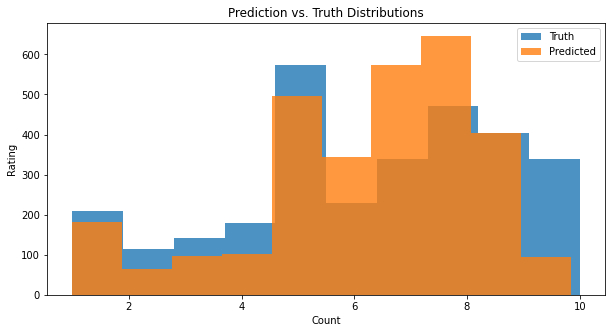

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(yt3, alpha = 0.8, label = "Truth")
ax.hist(treeReg4.predict(xt3), alpha = 0.8, label = "Predicted")
ax.set_title("Prediction vs. Truth Distributions")
ax.set_xlabel("Count")
ax.set_ylabel("Rating")
ax.legend()
fig.show()

/var/folders/qk/l24kr0vd3w1ccfx8ng5tp3l00000gr/T/ipykernel_83547/1899824113.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


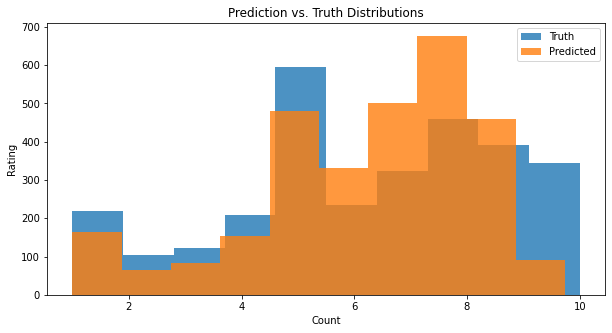

In [73]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(yt4, alpha = 0.8, label = "Truth")
ax.hist(treeReg5.predict(xt4), alpha = 0.8, label = "Predicted")
ax.set_title("Prediction vs. Truth Distributions")
ax.set_xlabel("Count")
ax.set_ylabel("Rating")
ax.legend()
fig.show()

In [316]:
a = np.array(test_y_u)
np.sum(np.abs(a - np.mean(a))) / a.shape[0]

2.079455566227805

## Low-Gamma Trials

In [92]:
def fit_random_forest(full_x, full_y):
    x, xt, y, yt = train_test_split(full_x, full_y, test_size = 0.2, random_state=6998)
    treeReg = RandomForestRegressor().fit(x,y)
    treereg_score = treeReg.score(xt, yt)
    print('Tree reg score:', treereg_score)
    print('MAE: ', mean_absolute_error(treeReg.predict(xt), yt))
    fig, ax = plt.subplots(figsize=(10,5))
    ax.hist(yt, alpha = 0.8, label = "Truth")
    ax.hist(treeReg.predict(xt), alpha = 0.8, label = "Predicted")
    ax.set_title("Prediction vs. Truth Distributions")
    ax.set_xlabel("Count")
    ax.set_ylabel("Rating")
    ax.legend()
    fig.show()

In [75]:
test_x_u, test_y_u = generate_regression_dataset(user_only, 15000, np.array(data_points_low_gamma, dtype=object))

0
3000
6000
9000
12000


In [76]:
test_x_ub, test_y_ub = generate_regression_dataset(user_and_business, 15000, np.array(data_points_low_gamma, dtype=object))

0
3000
6000
9000
12000


In [85]:
x_ubh_lg, y_ugb_lg = generate_regression_dataset(user_and_business_abbreviate_history, 15000, np.array(data_points_low_gamma, dtype=object))

0
3000
6000
9000
12000


In [86]:
len(x_ubh_lg)

15000

In [87]:
x_ubh_decay_lg, y_ubh_decay_lg = generate_regression_dataset(user_and_business_abbreviate_history_with_decay, 15000, np.array(data_points_low_gamma, dtype=object))

0
3000
6000
9000
12000


In [83]:
fit_random_forest(test_x_u, test_y_u)

Tree reg score: 0.2975576161869834
MAE:  1.0390319671624968


In [84]:
fit_random_forest(test_x_ub, test_y_ub)

Tree reg score: 0.46797744946193554
MAE:  0.8798756242207688


Tree reg score: 0.5723894760118242
MAE:  0.7481011595615515


/var/folders/qk/l24kr0vd3w1ccfx8ng5tp3l00000gr/T/ipykernel_83547/2564680113.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


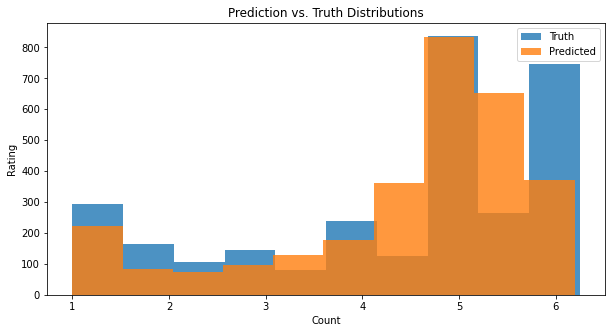

In [93]:
fit_random_forest(x_ubh_lg, y_ugb_lg)

Tree reg score: 0.5543283421855945
MAE:  0.7706855061142608


/var/folders/qk/l24kr0vd3w1ccfx8ng5tp3l00000gr/T/ipykernel_83547/2564680113.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


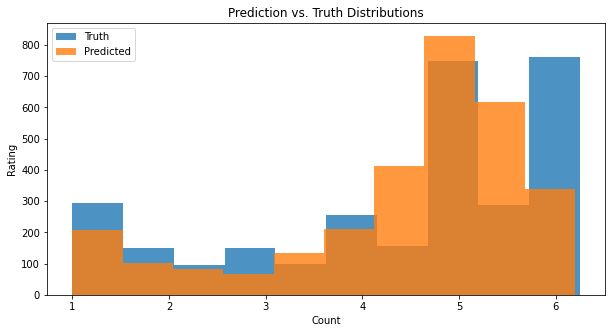

In [94]:
fit_random_forest(x_ubh_decay_lg, y_ubh_decay_lg)

## High Sequence Low Sequence

In [156]:
def create_user():
    v = np.zeros(14)
    return v

def process_event(user_vector, reward, review_count):
    # average stars
    user_vector[12] = (user_vector[12] * review_count + reward) / (review_count + 1)
    # review count
    user_vector[11] += 1
    
def process_embedding(embedding, business_embedding, reward, review_count):
    embedding *= review_count / (review_count + 1)
    embedding += 1/(review_count+1) * business_embedding * (reward - 3)

In [ ]:
user_keys = list(review_map.keys())

In [170]:
keys = np.random.choice(user_keys, 5000)

In [171]:
from collections import defaultdict

err_map = defaultdict(list)
for user in keys:
    new_user_sim = create_user()
    u_embedding = np.zeros(3 + enc.transform([[""] * 5]).shape[1])
    reviews = review_map[user]
    for i, review in enumerate(reviews):
        time, reward, action_taken = review
        business_embedding = get_event_embedding(action_taken, enc)
        bn = np.linalg.norm(business_embedding, ord = 2)
        un = np.linalg.norm(u_embedding, ord = 2)
        inp = None
        if bn == 0 or un == 0:
            inp = np.concatenate((new_user_sim, business_embedding, [0]))
        else:
            inp = np.concatenate((new_user_sim, business_embedding, [u_embedding.dot(business_embedding) / (un * bn)]))
        err = np.abs(treeReg5.predict([inp]) - true_q_func(reviews[i:]))
        err_map[i].append(err)
        
        # next step
        process_embedding(u_embedding, business_embedding, reward, i)
        process_event(new_user_sim, reward, i)

In [172]:
final_err_map = {}
for key, value in err_map.items():
    final_err_map[key] = np.mean(value)

/var/folders/qk/l24kr0vd3w1ccfx8ng5tp3l00000gr/T/ipykernel_83547/43996555.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


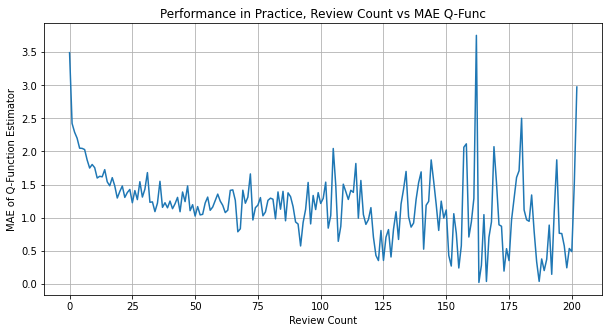

In [173]:
x, y = [], []
for key, value in final_err_map.items():
    x.append(int(key))
    y.append(value)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x,y)
ax.set_title("Performance in Practice, Review Count vs MAE Q-Func")
ax.set_ylabel("MAE of Q-Function Estimator")
ax.set_xlabel("Review Count")
ax.grid(True)
fig.show()

(array([2596., 2006., 1319.,  964.,  697.,  584.,  464.,  376.,  331.,
         329.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

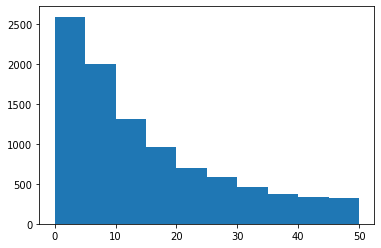

In [123]:
l = []
for x in test_x_ubh:
    l.append(x[11])
plt.hist(l, range = (0,50))

In [130]:
performance = []
for left, right in [(0,10), (11, 20), (21, 100), (101, np.inf)]:
    dataset = []
    y_dataset = []
    for i, x in enumerate(test_x_ubh):
        if left <= x[11] <= right:
            dataset.append(x)
            y_dataset.append(test_y_ubh[i])
    performance.append(mean_absolute_error(treeReg5.predict(dataset), y_dataset))

## Simulate Reinforcement Sequence

0
1000
2000
3000
4000
5000


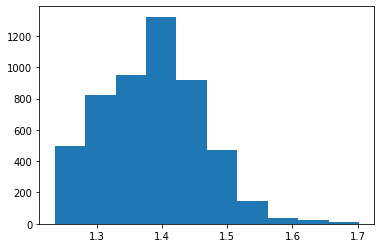

Q-Approx:  1.702187497317791
[business_id                                lqwbnNd_SXzkIK_pkU2FkA
name                                                       D'Vine
address                                    205 W Canon Perdido St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.418066
longitude                                             -119.702953
stars                                                         4.0
review_count                                                   26
is_open                                                         0
attributes      {'BusinessAcceptsCreditCards': 'True', 'GoodFo...
categories                         Sandwiches, Restaurants, Delis
hours           {'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...
Name: 29145, dtype: object]
Select a number


 0


Reward 1-5:


 1


0
1000
2000
3000
4000
5000


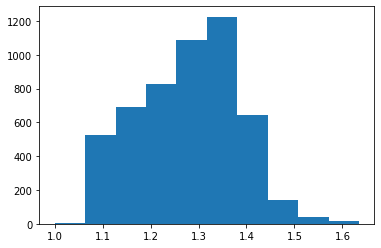

Q-Approx:  1.634687497317791
[business_id                                lqwbnNd_SXzkIK_pkU2FkA
name                                                       D'Vine
address                                    205 W Canon Perdido St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.418066
longitude                                             -119.702953
stars                                                         4.0
review_count                                                   26
is_open                                                         0
attributes      {'BusinessAcceptsCreditCards': 'True', 'GoodFo...
categories                         Sandwiches, Restaurants, Delis
hours           {'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...
Name: 29145, dtype: object]
Select a number


 0


Reward 1-5:


 1


0
1000
2000
3000
4000
5000


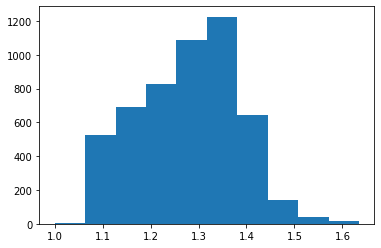

Q-Approx:  1.634687497317791
[business_id                                lqwbnNd_SXzkIK_pkU2FkA
name                                                       D'Vine
address                                    205 W Canon Perdido St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.418066
longitude                                             -119.702953
stars                                                         4.0
review_count                                                   26
is_open                                                         0
attributes      {'BusinessAcceptsCreditCards': 'True', 'GoodFo...
categories                         Sandwiches, Restaurants, Delis
hours           {'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...
Name: 29145, dtype: object]
Select a number


 0


Reward 1-5:


 1


0
1000
2000
3000
4000
5000


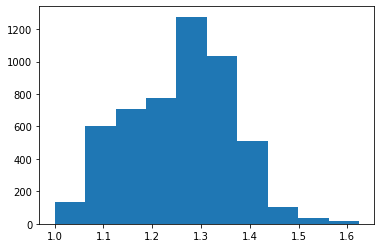

Q-Approx:  1.624062497317791
[business_id                                lqwbnNd_SXzkIK_pkU2FkA
name                                                       D'Vine
address                                    205 W Canon Perdido St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.418066
longitude                                             -119.702953
stars                                                         4.0
review_count                                                   26
is_open                                                         0
attributes      {'BusinessAcceptsCreditCards': 'True', 'GoodFo...
categories                         Sandwiches, Restaurants, Delis
hours           {'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...
Name: 29145, dtype: object]
Select a number


 0


Reward 1-5:


 1


0
1000
2000
3000
4000
5000


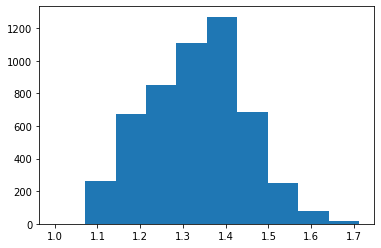

Q-Approx:  1.7118749970197678
[business_id                                lqwbnNd_SXzkIK_pkU2FkA
name                                                       D'Vine
address                                    205 W Canon Perdido St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.418066
longitude                                             -119.702953
stars                                                         4.0
review_count                                                   26
is_open                                                         0
attributes      {'BusinessAcceptsCreditCards': 'True', 'GoodFo...
categories                         Sandwiches, Restaurants, Delis
hours           {'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...
Name: 29145, dtype: object]
Select a number


KeyboardInterrupt: Interrupted by user

In [215]:
new_user_sim = create_user()
u_embedding = np.zeros(3 + enc.transform([[""] * 5]).shape[1])
reviews = review_map[user]
for t in range(5):
    inps = []
    business_embeddings = []
    for i, action_taken in enumerate(ca_bids):
        if i % 1000 == 0:
          print(i)
        business_embedding = get_event_embedding(action_taken, enc)
        bn = np.linalg.norm(business_embedding, ord = 2)
        un = np.linalg.norm(u_embedding, ord = 2)
        inp = None
        if bn == 0 or un == 0:
            inp = np.concatenate((new_user_sim, business_embedding, [0]))
        else:
            inp = np.concatenate((new_user_sim, business_embedding, [u_embedding.dot(business_embedding) / (un * bn)]))
        inps.append(inp)
        business_embeddings.append(business_embedding)
    ys = treeReg5.predict(inps)
    plt.hist(ys)
    plt.show()
    indices = np.argmax(ys)
    if type(indices) is np.int64:
        indices = [indices]
    print('Q-Approx: ', np.max(ys))
    print([business_map[ca_bids[x]] for x in indices])
    print('Select a number')
    selection = int(input())
    print('Reward 1-5:')
    reward = int(input())
    business_chosen_embedding = business_embeddings[indices[selection]]
    # next step
    process_embedding(u_embedding, business_embedding, reward, t)
    process_event(new_user_sim, reward, t)

0
1000
2000
3000
4000
5000


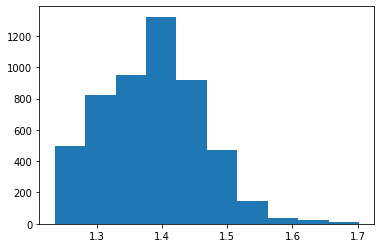

Q-Approx:  1.702187497317791
[business_id                                lqwbnNd_SXzkIK_pkU2FkA
name                                                       D'Vine
address                                    205 W Canon Perdido St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.418066
longitude                                             -119.702953
stars                                                         4.0
review_count                                                   26
is_open                                                         0
attributes      {'BusinessAcceptsCreditCards': 'True', 'GoodFo...
categories                         Sandwiches, Restaurants, Delis
hours           {'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...
Name: 29145, dtype: object]
Select a number


 0


Reward 1-5:


 5


0
1000
2000
3000
4000
5000


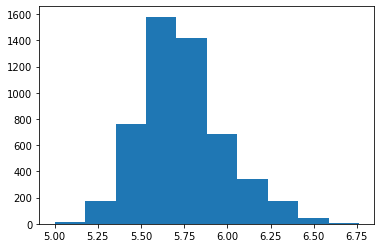

Q-Approx:  6.7625
[business_id                                znlrxrY4InSx7ekPZxoHRw
name                                  McConnell's Fine Ice Creams
address                                              728 State St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.419491
longitude                                             -119.698774
stars                                                         4.5
review_count                                                 1537
is_open                                                         1
attributes      {'RestaurantsPriceRange2': '2', 'BusinessAccep...
categories              Food, Ice Cream & Frozen Yogurt, Desserts
hours           {'Monday': '0:0-0:0', 'Tuesday': '12:0-21:0', ...
Name: 101797, dtype: object]
Select a number


 0


Reward 1-5:


 2


0
1000
2000
3000
4000
5000


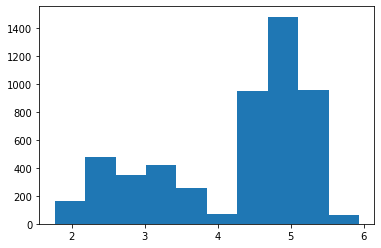

Q-Approx:  5.9346875
[business_id                                jMzcn59A2OYZ3zv2BoDdOw
name                                        Fernando's Smog Check
address                                             5940 Olney St
city                                                       Goleta
state                                                          CA
postal_code                                                 93117
latitude                                                34.429934
longitude                                             -119.829827
stars                                                         5.0
review_count                                                  193
is_open                                                         1
attributes      {'BusinessAcceptsCreditCards': 'True', 'WiFi':...
categories      Smog Check Stations, Automotive, Oil Change St...
hours           {'Monday': '0:0-0:0', 'Tuesday': '8:0-16:30', ...
Name: 23140, dtype: object]
Select a number


 0


Reward 1-5:


 1


0
1000
2000
3000
4000
5000


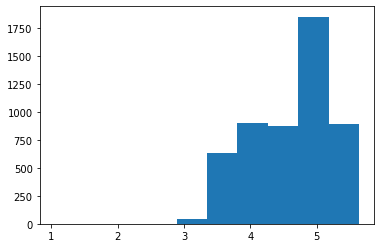

Q-Approx:  5.640322309061885
[business_id      tu5XjdlCKN3Ctv7WhXmlZQ
name                  Hien Motor Repair
address           257 Orange Ave, Ste C
city                             Goleta
state                                CA
postal_code                       93117
latitude                      34.434865
longitude                   -119.829852
stars                               4.0
review_count                         11
is_open                               1
attributes                         None
categories      Automotive, Auto Repair
hours                              None
Name: 84462, dtype: object]
Select a number


 0


Reward 1-5:


 1


0
1000
2000
3000
4000
5000


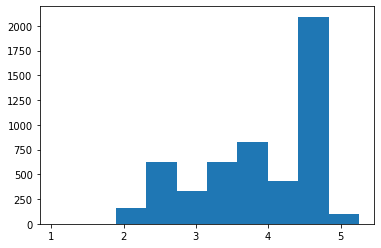

Q-Approx:  5.257724609375
[business_id                     kB4Uz9F9w7QkmNwjzQhPAw
name                                   Der Volks Werks
address                             626 E Gutierrez St
city                                     Santa Barbara
state                                               CA
postal_code                                      93103
latitude                                      34.42281
longitude                                  -119.686524
stars                                              4.5
review_count                                         9
is_open                                              0
attributes      {'BusinessAcceptsCreditCards': 'True'}
categories                     Automotive, Auto Repair
hours                                             None
Name: 28291, dtype: object]
Select a number


 0


Reward 1-5:


 1


In [216]:
new_user_sim = create_user()
u_embedding = np.zeros(3 + enc.transform([[""] * 5]).shape[1])
reviews = review_map[user]
for t in range(5):
    inps = []
    business_embeddings = []
    for i, action_taken in enumerate(ca_bids):
        if i % 1000 == 0:
          print(i)
        business_embedding = get_event_embedding(action_taken, enc)
        bn = np.linalg.norm(business_embedding, ord = 2)
        un = np.linalg.norm(u_embedding, ord = 2)
        inp = None
        if bn == 0 or un == 0:
            inp = np.concatenate((new_user_sim, business_embedding, [0]))
        else:
            inp = np.concatenate((new_user_sim, business_embedding, [u_embedding.dot(business_embedding) / (un * bn)]))
        inps.append(inp)
        business_embeddings.append(business_embedding)
    ys = treeReg5.predict(inps)
    plt.hist(ys)
    plt.show()
    indices = np.argmax(ys)
    if type(indices) is np.int64:
        indices = [indices]
    print('Q-Approx: ', np.max(ys))
    print([business_map[ca_bids[x]] for x in indices])
    print('Select a number')
    selection = int(input())
    print('Reward 1-5:')
    reward = int(input())
    business_chosen_embedding = business_embeddings[indices[selection]]
    # next step
    process_embedding(u_embedding, business_embedding, reward, t)
    process_event(new_user_sim, reward, t)

0
1000
2000
3000
4000
5000


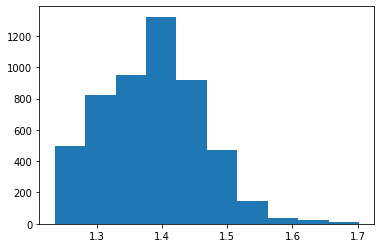

Q-Approx:  1.702187497317791
[business_id                                lqwbnNd_SXzkIK_pkU2FkA
name                                                       D'Vine
address                                    205 W Canon Perdido St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.418066
longitude                                             -119.702953
stars                                                         4.0
review_count                                                   26
is_open                                                         0
attributes      {'BusinessAcceptsCreditCards': 'True', 'GoodFo...
categories                         Sandwiches, Restaurants, Delis
hours           {'Monday': '8:0-16:0', 'Tuesday': '8:0-16:0', ...
Name: 29145, dtype: object]
Select a number


 0


Reward 1-5:


 5


0
1000
2000
3000
4000
5000


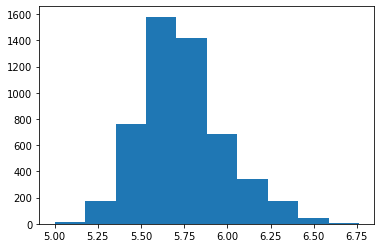

Q-Approx:  6.7625
[business_id                                znlrxrY4InSx7ekPZxoHRw
name                                  McConnell's Fine Ice Creams
address                                              728 State St
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.419491
longitude                                             -119.698774
stars                                                         4.5
review_count                                                 1537
is_open                                                         1
attributes      {'RestaurantsPriceRange2': '2', 'BusinessAccep...
categories              Food, Ice Cream & Frozen Yogurt, Desserts
hours           {'Monday': '0:0-0:0', 'Tuesday': '12:0-21:0', ...
Name: 101797, dtype: object]
Select a number


 0


Reward 1-5:


 4


0
1000
2000
3000
4000
5000


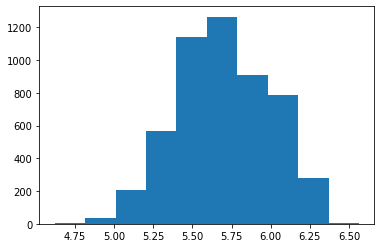

Q-Approx:  6.56375
[business_id                                u3uB0GD7cVf5NC-AFHdwnQ
name                                       Golden Line Coffee Bar
address                     618 Anacapa St, Ste A, Villa Wine Bar
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.419541
longitude                                             -119.696359
stars                                                         5.0
review_count                                                   10
is_open                                                         1
attributes      {'RestaurantsDelivery': 'False', 'RestaurantsT...
categories      Pop-Up Restaurants, Coffee & Tea, Food, Restau...
hours           {'Friday': '7:30-14:0', 'Saturday': '7:30-14:0...
Name: 44547, dtype: object]
Select a number


 0


Reward 1-5:


 4


0
1000
2000
3000
4000
5000


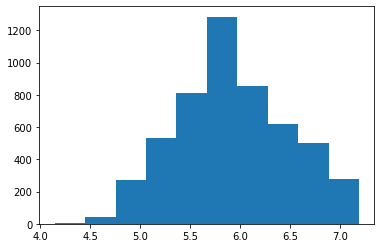

Q-Approx:  7.19375
[business_id                                VhWtlyWAH6Lw_XBXuKDWng
name                                               LaoWang Burger
address                                        231 S Magnolia Ave
city                                                       Goleta
state                                                          CA
postal_code                                                 93117
latitude                                                34.435829
longitude                                             -119.827639
stars                                                         4.5
review_count                                                   11
is_open                                                         0
attributes      {'RestaurantsPriceRange2': '1', 'RestaurantsAt...
categories      Food, Restaurants, Food Delivery Services, Chi...
hours           {'Wednesday': '17:0-21:30', 'Thursday': '17:0-...
Name: 51513, dtype: object]
Select a number


 0


Reward 1-5:


 5


0
1000
2000
3000
4000
5000


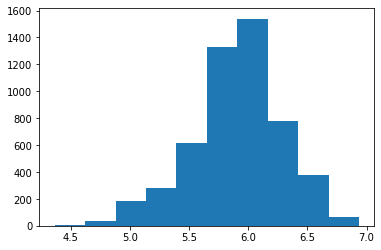

Q-Approx:  6.936875
[business_id                                u3uB0GD7cVf5NC-AFHdwnQ
name                                       Golden Line Coffee Bar
address                     618 Anacapa St, Ste A, Villa Wine Bar
city                                                Santa Barbara
state                                                          CA
postal_code                                                 93101
latitude                                                34.419541
longitude                                             -119.696359
stars                                                         5.0
review_count                                                   10
is_open                                                         1
attributes      {'RestaurantsDelivery': 'False', 'RestaurantsT...
categories      Pop-Up Restaurants, Coffee & Tea, Food, Restau...
hours           {'Friday': '7:30-14:0', 'Saturday': '7:30-14:0...
Name: 44547, dtype: object]
Select a number


 0


Reward 1-5:


 4


In [217]:
new_user_sim = create_user()
u_embedding = np.zeros(3 + enc.transform([[""] * 5]).shape[1])
reviews = review_map[user]
for t in range(5):
    inps = []
    business_embeddings = []
    for i, action_taken in enumerate(ca_bids):
        if i % 1000 == 0:
          print(i)
        business_embedding = get_event_embedding(action_taken, enc)
        bn = np.linalg.norm(business_embedding, ord = 2)
        un = np.linalg.norm(u_embedding, ord = 2)
        inp = None
        if bn == 0 or un == 0:
            inp = np.concatenate((new_user_sim, business_embedding, [0]))
        else:
            inp = np.concatenate((new_user_sim, business_embedding, [u_embedding.dot(business_embedding) / (un * bn)]))
        inps.append(inp)
        business_embeddings.append(business_embedding)
    ys = treeReg5.predict(inps)
    plt.hist(ys)
    plt.show()
    indices = np.argmax(ys)
    if type(indices) is np.int64:
        indices = [indices]
    print('Q-Approx: ', np.max(ys))
    print([business_map[ca_bids[x]] for x in indices])
    print('Select a number')
    selection = int(input())
    print('Reward 1-5:')
    reward = int(input())
    business_chosen_embedding = business_embeddings[indices[selection]]
    # next step
    process_embedding(u_embedding, business_embedding, reward, t)
    process_event(new_user_sim, reward, t)